In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mpl_defaults
import normal_He3_params as he3
import seaborn as sns
idx = pd.IndexSlice
from numpy.fft import fft 

%matplotlib inline

# The spatial dependent pair potential

Text(0.5, 1.0, 'Interaction/potential spatial dependence')

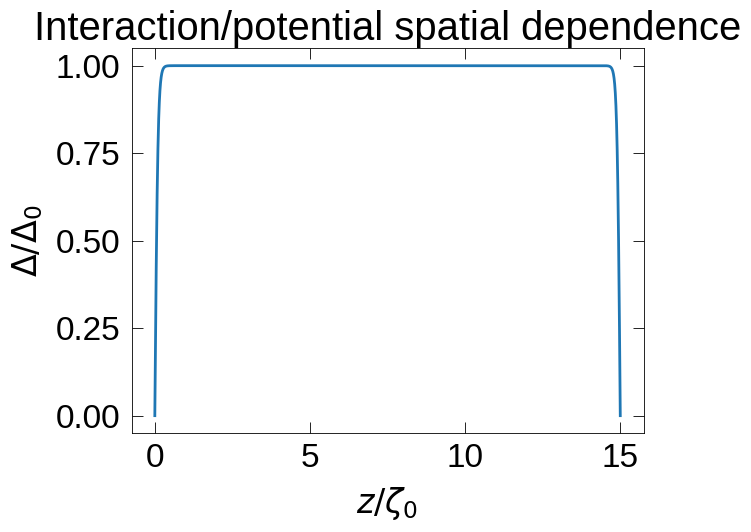

In [10]:
def gap_perp_component(z, l = 10, strech = 1):
    return np.where(z<l/2, np.tanh(strech*z), np.tanh(strech*(z-l))*-1)


P = 29.3

channel_height = 1.1E-6
coherence_length = he3.v_Fermi(P)*he3.hbar/(2*np.pi*he3.kb*he3.Tc_line(P)*1E-3)

# z_real = np.linspace(0, 15, 2000)
# dz = z[1]-z[0]

dz = 1E-2/2
zmin = 0
zmax = 15
z_real = np.arange(zmin, zmax+dz, dz)
z = z_real
# z = z_real/z_real.max()*channel_height/coherence_length

gap_spatial_dep = gap_perp_component(z, l = z.max()-z.min(), strech= 10)
tanh_mat = np.zeros((len(z), len(z)))
np.fill_diagonal(tanh_mat, gap_spatial_dep)

fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(z, gap_spatial_dep)

ax.set_xlabel(r'$z/\zeta_0$')
ax.set_ylabel(r'$\Delta/\Delta_0$')
ax.set_title('Interaction/potential spatial dependence')

<font size = 5>

* The interaction potential goes to zeros at the boundaries of a slab.
* The slab has a thickness 15 $\zeta_0$ 

# Bogoliubov deGennes (BdG) equation

* A hamiltonian/matrix that describes the quantum states in nanoconfined superfluid helium-3

$$
\epsilon = -\frac{\hbar^2}{2m^*}\frac{\partial^2}{\partial z^2} - \mu
$$

$$
\Delta_z = \frac{\Delta_0 }{p_F}\frac{\hbar}{i}\tanh\left(z/\zeta_0\right)\frac{\partial}{\partial z}
$$

$$
H\ket{\psi(z)} = E_n\ket{\psi(z)}
$$

<!-- $$
\varepsilon = \epsilon \bold{1}_\sigma \tau_3 
$$

$$
\Delta = i \bold{\sigma}\sigma_y \cdot \bold{d(\bold{p})}
\Delta_z = \sigma_x d_z
 
$$ -->

$$

H = 
\begin{pmatrix}
\epsilon & 0 & 0 & \Delta_z \\
0& \epsilon & \Delta_z & 0\\
0& \Delta_z^\dag & -\epsilon & 0\\
\Delta_z^\dag & 0 & 0 & -\epsilon \\

\end{pmatrix}
$$

The coefficient on the kinetic energy operator
$$
\alpha = \frac{\pi^2}{1.76} \frac{T_c}{T_F} 
$$

The coefficient on the pair potential: 
$$
\beta = \frac{\pi}{i}\frac{1.76T_c}{T_F}
$$

The chemical potential:
$$
\kappa = \frac{\mu}{\Delta_0}
 =\frac{T_F}{1.76T_c}
$$

$$
K = -\alpha \frac{\partial^2}{\partial z^2} - \kappa
$$

$$
U = \beta\tanh(z/\zeta_0) \frac{\partial}{\partial z}
$$

$$
H = 
\begin{pmatrix}
K & 0 & 0 & U \\
0& K & U & 0\\
0& U^\dag & -K & 0\\
U^\dag & 0 & 0 & -K \\

\end{pmatrix}
$$

$$
H\ket{\psi\left(z/\zeta_0\right)} = E_n/\Delta_0 \ket{\psi(z/\zeta_0)}
$$

This makes the eigenvalues
$$
\lambda_n = \frac{E_n}{\Delta_0}
$$

I think my bound states are the eigenvalues centered around 0, no need for subtracting $E_F$

# Diagonalizing the Hamiltonian

### Define boundary conditions

In [11]:
# Boundary conditions chosen so that solution decays outside the boundaries

def d2dx2(num, dx):
    mat = np.zeros((num+1, num+1))
    for i in range(num):
        mat[i, i] = -2
        try:
            mat[i, i-1] = 1
            mat[i, i+1] = 1
        except:pass
    return mat[0:num, 0:num]/dx**2

def ddx(num, dx):
    mat = np.zeros((num+1, num+1))
    for i in range(num):
        try:
            mat[i, i-1] = -1
            mat[i, i+1] = 1
        except:pass
    return mat[0:num, 0:num]/dx



### Solve the eigenvalue problem

In [4]:
gam = 1.76

energy_scale = he3.Tc_line(P)*1E-3/he3.T_Fermi(P) #Tc/Tf
alpha = np.pi**2/gam *  energy_scale
beta= np.pi/(1j)*energy_scale
kappa = energy_scale**-1/gam #Tf/Tc



K = -1*alpha*d2dx2(len(z), dz) - kappa*np.identity(n = len(z))


U = beta * np.matmul(tanh_mat, ddx(len(z), dz))

mat0 = np.zeros((len(z), len(z)))
H = np.block([
    [K, mat0, mat0, U],
    [mat0, K, U, mat0], 
    [mat0, np.conjugate(U).T, -K, mat0],
    [np.conjugate(U).T, mat0, mat0, -K]
]) 

# subtract off the fermi energy
# H = H+kappa*np.identity(n = H.shape[0])

eigval, eigvec = np.linalg.eigh(H)
E = eigval
pos_E = E[E>0]
neg_E = E[E<0]


### Reformat the solutions to the Hamiltonian

In [5]:
def psi(vecs, En, x):
    df= pd.concat([component_df(vecs, En, i, x) for i in np.arange(4)], axis = 1).T.sort_index().T
    return df

def component_df(vecs:np.array, En, component:int, x:np.array) -> pd.DataFrame:
    start = component*len(En)//4
    stop = (component+1)*len(En)//4

    pos_E = En[En>=0]
    neg_E = En[En<0]


    # particle_high_idx = np.where(En == pos_E[-1])[0][0]
    # hole_high_idx = np.where(En == neg_E[0])[0][0]

    # data = vecs[start:stop, hole_high_idx:particle_high_idx+1]
    data = vecs[start:stop, :]

    En_index = np.concatenate( [
        np.flip(np.arange(len(neg_E))*-1)-1,
        np.arange(len(pos_E))+1,
        ])
    df = pd.DataFrame(
        data, 
        index = x,
        columns = pd.MultiIndex.from_product([
            En_index,
            [f'c_{component}'],
        ])
    )

    df.columns.rename('En', level = 0, inplace = True)
    df.columns.rename(f'c_i', level = 1, inplace = True)
    df.index.rename('x', inplace = True)
    return df

psi_df = psi(eigvec, E, z)


### Computation of probability density functions from wavefunctions

In [6]:
def pandas_fft(data) -> pd.Series:
    return pd.DataFrame(
        data = fft(data),
        index = data.index
    )


pdf =psi_df.T.groupby('En', group_keys=False).apply(
    lambda x: (np.sum(np.abs(x)*np.abs(x), axis = 0))).T


psi_fft =psi_df.T.groupby('En', group_keys = False).apply(pandas_fft).T
k = np.fft.fftfreq(len(psi_fft))*len(psi_fft)/((z.max()-z.min()))*(2*np.pi)
p = k*(np.pi * energy_scale)
psi_fft.set_index(k, inplace = True)
psi_fft.index.name = 'k'
psi_fft

psi_modes = psi_fft.T.groupby('En', group_keys =False).apply(
    lambda x: np.sum(np.abs(x), axis =0)).T
psi_modes.index.name = 'k'

# The top level column is the energy eigenstate
# The index is the momentum eigenstate
psi_modes
# psi_modes.to_csv()

En,-6000,-5999,-5998,-5997,-5996,-5995,-5994,-5993,-5992,-5991,...,5995,5996,5997,5998,5999,6000,6001,6002,6003,6004
k,,,,,,,,,,,,,,,,,,,,,
0.000000,0.000014,0.000014,2.323314e-09,2.323313e-09,0.000041,0.000041,4.646629e-09,4.646627e-09,0.000068,0.000068,...,0.000068,0.000068,2.434809e-09,2.434798e-09,0.000041,0.000041,1.217402e-09,1.217401e-09,0.000014,0.000014
0.418879,0.000014,0.000014,3.060018e-08,3.060018e-08,0.000041,0.000041,6.120042e-08,6.120042e-08,0.000068,0.000068,...,0.000068,0.000068,5.898880e-08,5.898880e-08,0.000041,0.000041,2.949438e-08,2.949437e-08,0.000014,0.000014
0.837758,0.000014,0.000014,5.887720e-08,5.887720e-08,0.000041,0.000041,1.177545e-07,1.177545e-07,0.000068,0.000068,...,0.000068,0.000068,1.155431e-07,1.155431e-07,0.000041,0.000041,5.777149e-08,5.777149e-08,0.000014,0.000014
1.256637,0.000014,0.000014,8.715452e-08,8.715452e-08,0.000041,0.000041,1.743092e-07,1.743092e-07,0.000068,0.000068,...,0.000068,0.000068,1.720980e-07,1.720980e-07,0.000041,0.000041,8.604891e-08,8.604891e-08,0.000014,0.000014
1.675516,0.000014,0.000014,1.154323e-07,1.154323e-07,0.000041,0.000041,2.308649e-07,2.308649e-07,0.000068,0.000068,...,0.000068,0.000068,2.286538e-07,2.286538e-07,0.000041,0.000041,1.143268e-07,1.143268e-07,0.000014,0.000014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-2.094395,0.000014,0.000014,1.437107e-07,1.437107e-07,0.000041,0.000041,2.874217e-07,2.874217e-07,0.000068,0.000068,...,0.000068,0.000068,2.852109e-07,2.852109e-07,0.000041,0.000041,1.426053e-07,1.426053e-07,0.000014,0.000014
-1.675516,0.000014,0.000014,1.154323e-07,1.154323e-07,0.000041,0.000041,2.308649e-07,2.308649e-07,0.000068,0.000068,...,0.000068,0.000068,2.286538e-07,2.286538e-07,0.000041,0.000041,1.143268e-07,1.143268e-07,0.000014,0.000014
-1.256637,0.000014,0.000014,8.715452e-08,8.715452e-08,0.000041,0.000041,1.743092e-07,1.743092e-07,0.000068,0.000068,...,0.000068,0.000068,1.720980e-07,1.720980e-07,0.000041,0.000041,8.604891e-08,8.604891e-08,0.000014,0.000014


### Visualize the ground state solutions

Text(0, 0.5, '$E/\\Delta_0$')

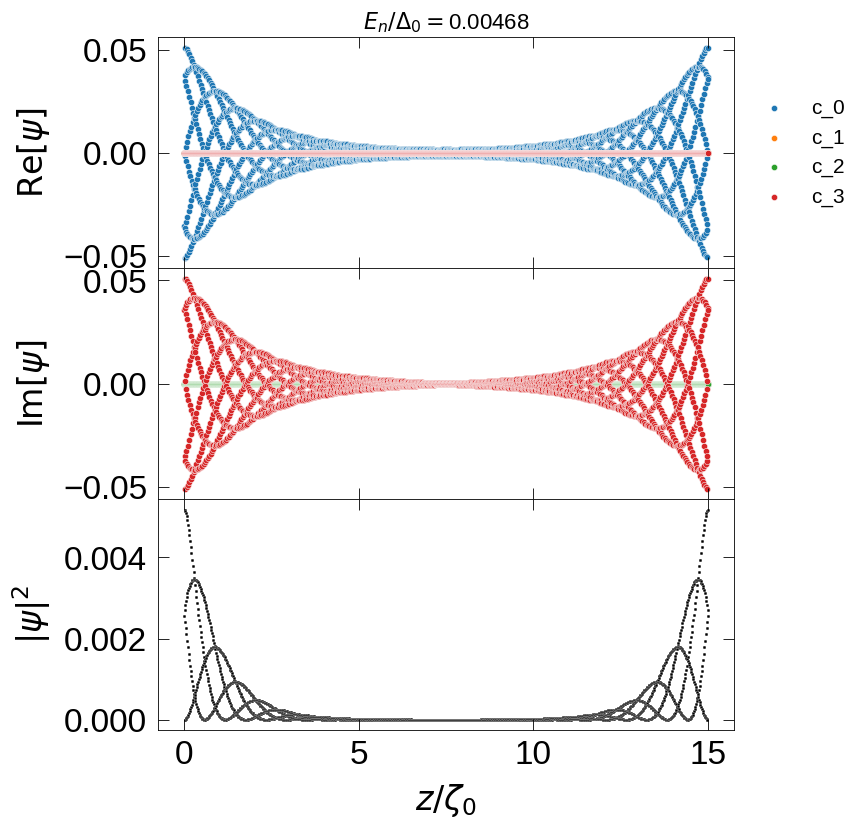

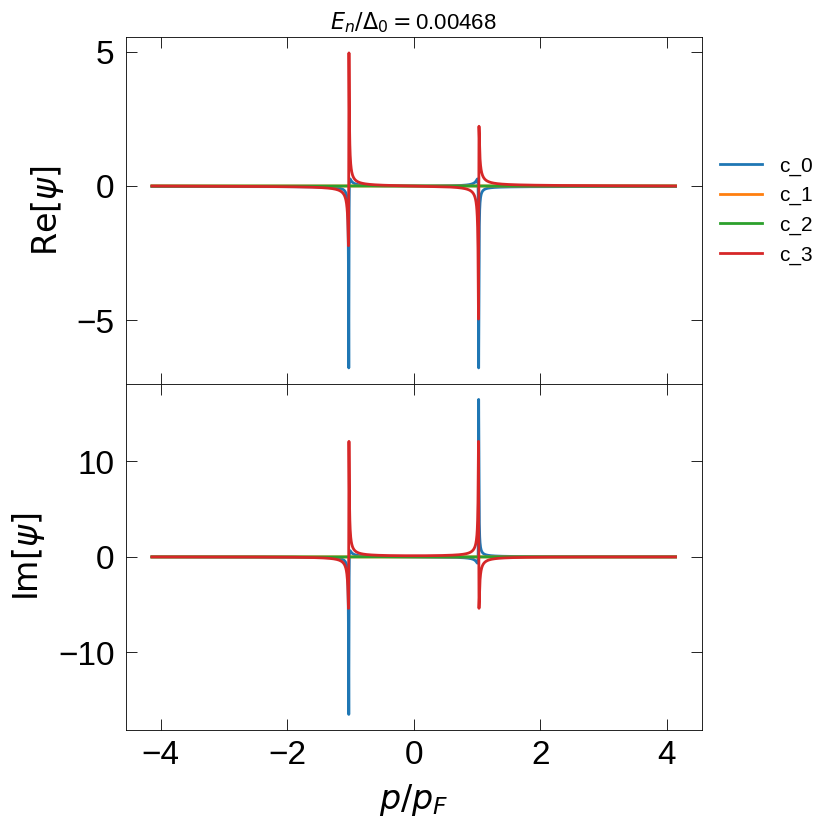

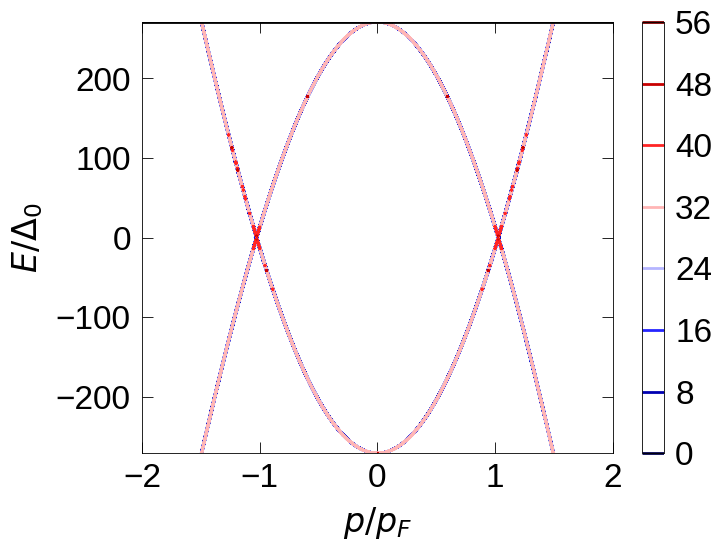

In [7]:
i =1

data = psi_df.loc[:, i]

fig, ax = plt.subplots(3, sharex=True, figsize = (9, 9))
fig.subplots_adjust(hspace = 0)
for col in data.columns:
    if i>0: title = pos_E[(i-1)]
    else: title = np.flip(neg_E)[(-1*i-1)]
    ax[0].set_title(r'$E_n/\Delta_0=$'+'{:.3g}'.format(title), fontsize = 16)

    sns.scatterplot(x=data.index, y= np.real(data.loc[:, col]), alpha = 1, ax = ax[0], s = 20, label = col)
    sns.scatterplot(x=data.index, y=np.imag(data.loc[:, col]), alpha = 1, ax = ax[1], s =20)
    sns.scatterplot(pdf.loc[:, i], color = 'k')

    ax[2].set_xlabel(r'$z/\zeta_0$')

    ax[0].set_ylabel(r'$\text{Re}[{\psi}]$')
    ax[1].set_ylabel(r'$\text{Im}[{\psi}]$')
    ax[2].set_ylabel(r'$|{\psi}|^2$')
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 15)
# fig.savefig('figures/BdG zero energy mode.pdf')



fig, ax = plt.subplots(2, sharex=True, figsize = (9, 9))
fig.subplots_adjust(hspace = 0)
data = psi_fft.loc[:, i]

for col in data.columns:
    
    if i>0: title = pos_E[(i-1)]
    else: title = np.flip(neg_E)[(-1*i-1)]
    ax[0].set_title(r'$E_n/\Delta_0=$'+'{:.3g}'.format(title), fontsize = 16)

    sns.lineplot(x=p, y= np.real(data.loc[:, col]), alpha = 1, ax = ax[0], label = col)
    sns.lineplot(x=p, y=np.imag(data.loc[:, col]), alpha = 1, ax = ax[1], )

    ax[1].set_xlabel(r'$p/p_F$')
    ax[0].set_ylabel(r'$\text{Re}[{\psi}]$')
    ax[1].set_ylabel(r'$\text{Im}[{\psi}]$')
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 15)

fig, ax = plt.subplots()
contour = ax.contour(p, eigval, psi_modes.T, cmap = 'seismic')
cbar = fig.colorbar(contour)
ax.axhline(kappa, color='k')
ax.set_xlim(-2, 2)
ax.set_ylim(-kappa, kappa)

ax.set_xlabel(r'$p/p_F$')
ax.set_ylabel(r'$E/\Delta_0$')
# fig.savefig('figures/Bdg dispersion relation.pdf')
    

<font size = 4>

<!-- * <span style="color:red">* Please ignore the error message ^, the code below ran successfully on a new instance of the notebook.
</span> -->

* The first plot is the spatial dependence of the wave function for a topological bound state.
* The 2nd plot is a Fourier transform of the 1st plot.
* The 3rd function is a map of the "dispersion relation." It describes the energy eigenvalues for a given momentum eigenstate.

# Andreev equation

In [12]:
# z= np.linspace(0, 100, 1000)
# dz = z[1]-z[0]
# tanh_mat = np.zeros((len(z), len(z)))
# gap_spatial_dep = gap_perp_component(z, z[-1]-z[0])
# np.fill_diagonal(tanh_mat, gap_spatial_dep)

T = ddx(len(z), dz)*2*np.pi/gam
V = np.matmul(tanh_mat, ddx(len(z), dz))*np.pi/1j * energy_scale
# mat0 = np.zeros((len(z), len(z)))
H_andreev = np.block([
    [T, mat0, mat0, V],
    [mat0, T, V, mat0],
    [mat0, np.conjugate(V).T, -1*T, mat0],
    [np.conjugate(V), mat0, mat0, -T]
])

eigval_a, eigvec_a = np.linalg.eigh(H_andreev)
E_a = eigval_a
pos_Ea = E_a[E_a>0]
neg_Ea = E_a[E_a<0]
psi_a_df = psi(eigvec_a, E_a, z)


In [13]:
pdf_a =psi_a_df.T.groupby('En', group_keys=False).apply(
    lambda x: (np.sum(np.abs(x)*np.abs(x), axis = 0))).T


psi_a_fft = psi_a_df.T.groupby('En', group_keys=False).apply(pandas_fft).T
k_a = np.fft.fftfreq(len(psi_a_fft))*len(psi_a_fft)/((z.max()-z.min()))*(2*np.pi)
p_a = k_a*(np.pi * energy_scale)
psi_a_fft.set_index(k_a, inplace = True)
psi_a_fft.index.name = 'k'
psi_a_fft

psi_a_modes = psi_a_fft.T.groupby('En', group_keys =False).apply(
    lambda x: np.sum(np.abs(x), axis =0)).T
psi_a_modes.index.name = 'k'


Text(0, 0.5, '$E/\\Delta_0$')

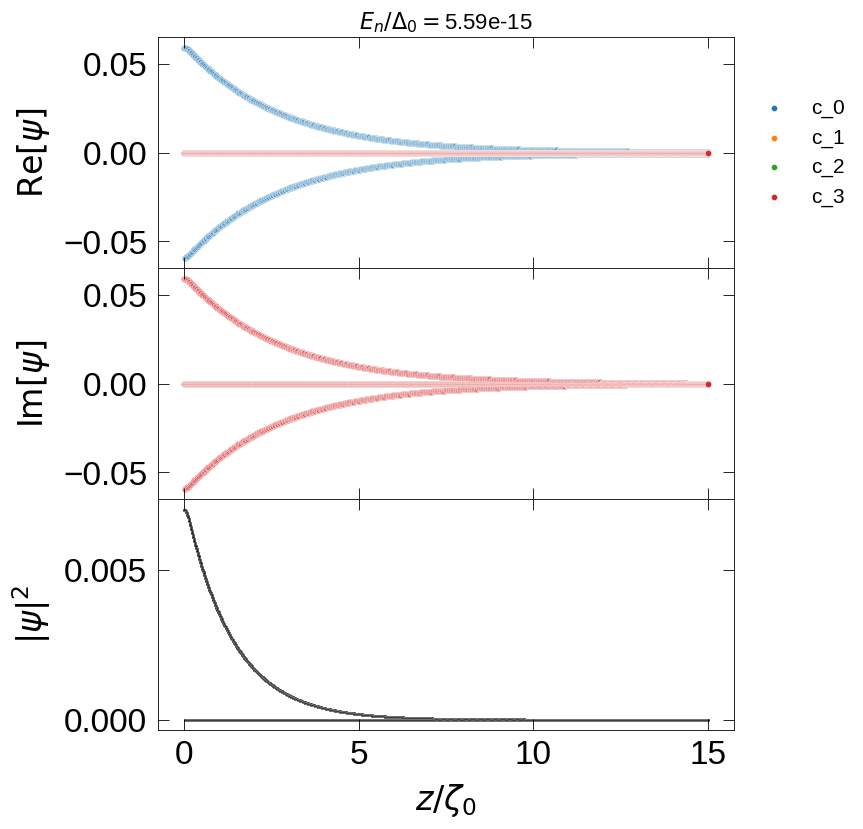

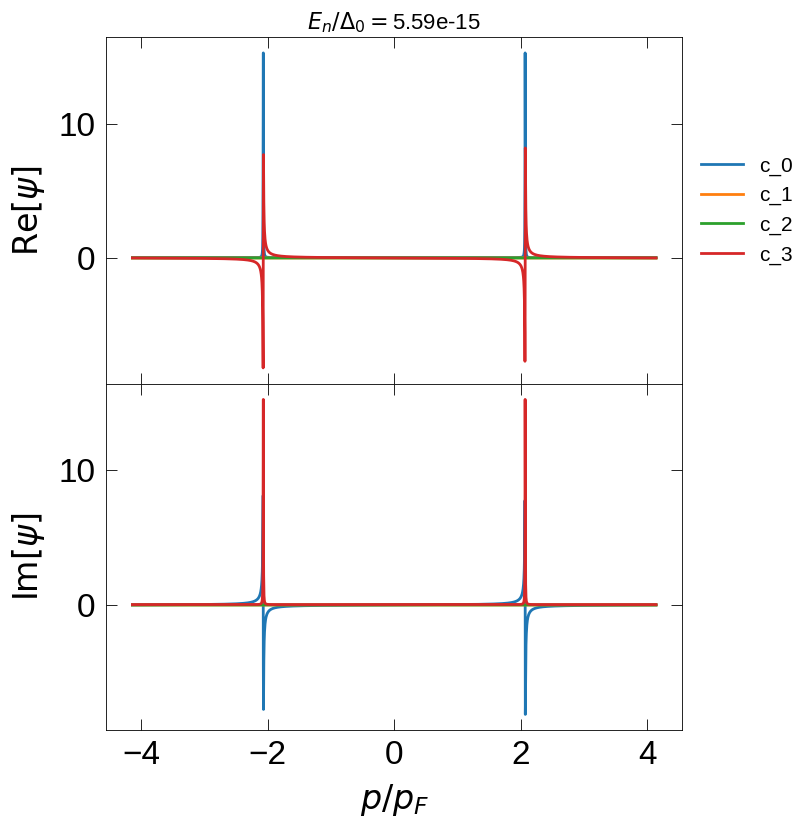

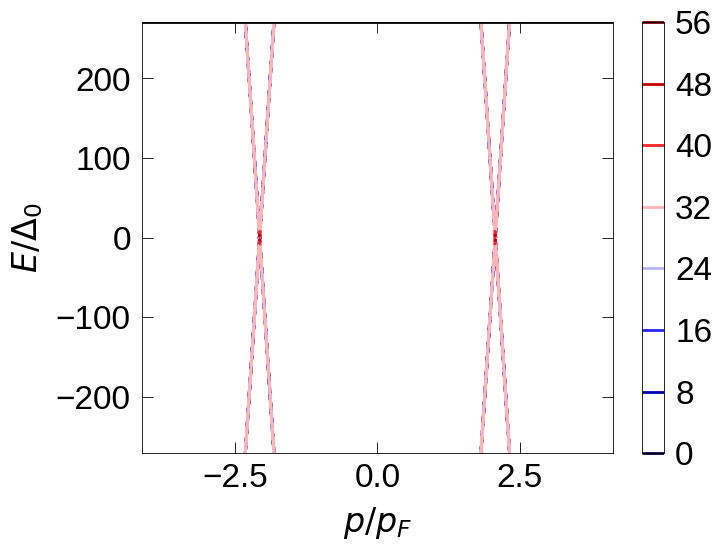

In [14]:
i =1

data = psi_a_df.loc[:, i]

fig, ax = plt.subplots(3, sharex=True, figsize = (9, 9))
fig.subplots_adjust(hspace = 0)
for col in data.columns:
    if i>0: title = pos_Ea[(i-1)]
    else: title = np.flip(neg_Ea)[(-1*i-1)]
    ax[0].set_title(r'$E_n/\Delta_0=$'+'{:.3g}'.format(title), fontsize = 16)

    sns.scatterplot(x=data.index, y= np.real(data.loc[:, col]), alpha = 1, ax = ax[0], s = 20, label = col)
    sns.scatterplot(x=data.index, y=np.imag(data.loc[:, col]), alpha = 1, ax = ax[1], s =20)
    sns.scatterplot(pdf_a.loc[:, i], color = 'k')

    ax[2].set_xlabel(r'$z/\zeta_0$')

    ax[0].set_ylabel(r'$\text{Re}[{\psi}]$')
    ax[1].set_ylabel(r'$\text{Im}[{\psi}]$')
    ax[2].set_ylabel(r'$|{\psi}|^2$')
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 15)

# fig.savefig('figures/Andreev zero energy mode.pdf')


fig, ax = plt.subplots(2, sharex=True, figsize = (9, 9))
fig.subplots_adjust(hspace = 0)
data = psi_a_fft.loc[:, i]

for col in data.columns:
    
    if i>0: title = pos_Ea[(i-1)]
    else: title = np.flip(neg_Ea)[(-1*i-1)]
    ax[0].set_title(r'$E_n/\Delta_0=$'+'{:.3g}'.format(title), fontsize = 16)

    sns.lineplot(x=p_a, y= np.real(data.loc[:, col]), alpha = 1, ax = ax[0], label = col)
    sns.lineplot(x=p_a, y=np.imag(data.loc[:, col]), alpha = 1, ax = ax[1], )

    ax[1].set_xlabel(r'$p/p_F$')
    ax[0].set_ylabel(r'$\text{Re}[{\psi}]$')
    ax[1].set_ylabel(r'$\text{Im}[{\psi}]$')
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 15)

fig, ax = plt.subplots()
contour = ax.contour(p_a, eigval_a, psi_a_modes.T, cmap = 'seismic')
cbar = fig.colorbar(contour)
ax.set_ylim(-kappa, kappa)
ax.axhline(kappa, color='k')
ax.set_xlabel(r'$p/p_F$')
ax.set_ylabel(r'$E/\Delta_0$')
# fig.savefig('figures/Andreev dispersion relation.pdf')
    